<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/MiniProjects/M6_NB_MiniProject_4_Urban_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Urban Traffic Flow Prediction using Graph Convolution Network - LSTM

## Learning Objectives

At the end of the Mini Project, you will be able to :

* forecast traffic flow using Graph Convolutional Network and LSTM
* understand the graph structured data and implement the forecasting model

## Information

Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is important for

- urban traffic planning,
- traffic management, and
- traffic control.

Traffic forecasting is a challenging issue because of the constraints of the urban road network topological structure and the law of dynamic change with time (spatial dependence and temporal dependence). To capture the spatial and temporal dependence simultaneously, a neural network-based traffic forecasting method called the temporal graph convolutional network (T-GCN) model is very useful. It is a combination of the graph convolutional network (GCN) and gated recurrent unit (GRU).

- Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the T-GCN model is employed to traffic forecasting based on the urban road network. T-GCN model can obtain the spatio-temporal correlation from traffic data and the predictions outperform state-of-art baselines on real-world traffic datasets.

Reference: https://arxiv.org/abs/1811.05320

## Dataset



Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning.

This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). This dataset contains traffic speeds from Mar-1 to Mar-7, 2012 of 207 sensors, recorded every 5 minutes.  There are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes. This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207 for 7 days (12X24X7).

Data Source:
https://github.com/lehaifeng/T-GCN/tree/master/data

## Problem Statement

#### Forecasting urban traffic flow using spatio-temporal data with combined Graph Convolution + LSTM model

## Grading = 10 Points

In [1]:
#@title Download dataset
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_adj.csv
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_speed.csv
!pip -qq install chardet
!pip -qq install git+https://github.com/VenkateshwaranB/stellargraph.git

  Preparing metadata (setup.py) ... done


### Import required packages

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
import stellargraph as sg
from stellargraph.layer import GCN
from stellargraph.layer import GCN_LSTM
import networkx as nx

### Data loading and preparation ( 2 points)

In [9]:
adj_path = "/content/los_adj.csv"
speed_data_path= "/content/los_speed.csv"

In [24]:
# YOUR CODE HERE
df_adj = pd.read_csv(adj_path)
df_speed = pd.read_csv(speed_data_path)

In [25]:
df_adj.head()

,1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.179,0.180,0.119804092,0.181,0.182,0.183,0.184,0.185,0.186,0.187
0,0.0,1.000000,0.717438,0.000000,0.000000,0.000000,0.000000,0.390457,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.717438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,1.000000,0.633722,0.894812,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.633722,1.000000,0.361432,0.135197,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.894812,0.361432,1.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Get df excluding 1st column of df_adj
df_adj.shape

(206, 207)

In [27]:
df_adj

,1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.179,0.180,0.119804092,0.181,0.182,0.183,0.184,0.185,0.186,0.187
0,0.0,1.000000,0.717438,0.000000,0.000000,0.000000,0.000000,0.390457,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.717438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,1.000000,0.633722,0.894812,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.633722,1.000000,0.361432,0.135197,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.894812,0.361432,1.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.120698,1.0,0.0,0.0,0.0,0.0
202,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
203,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.221904,...,0.132771,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
204,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0


In [ ]:
# get a df_adj with stripping first column
new_df_adj = df_adj.iloc[:,1:]
# Replace column names with same name as row, since its an adj matrix
new_df_adj.columns = new_df_adj.index

In [53]:
new_df_adj

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,1.000000,0.717438,0.000000,0.000000,0.000000,0.000000,0.390457,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.717438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,1.000000,0.633722,0.894812,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.633722,1.000000,0.361432,0.135197,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.894812,0.361432,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.120698,1.0,0.0,0.0,0.0,0.0
202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.221904,0.0,...,0.132771,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0


#### Plotting the time series of 10 sensors data

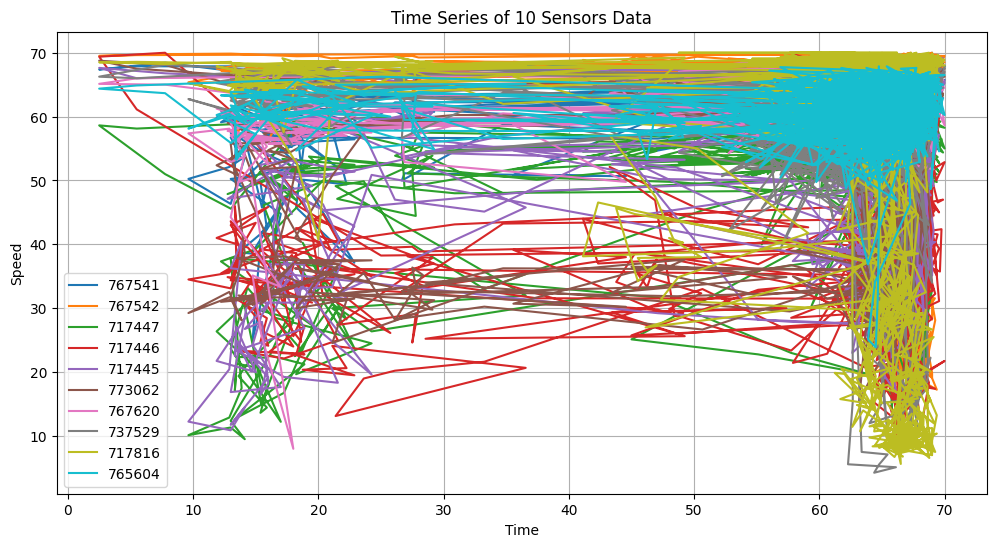

In [6]:
# YOUR CODE HERE
# Select 10 sensors (columns) to plot
sensors_to_plot = df_speed.columns[1:11]  # Selecting columns 1-10 (excluding time)

# Plot the time series data for the selected sensors
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

for sensor in sensors_to_plot:
    plt.plot(df_speed.iloc[:, 0], df_speed[sensor], label=sensor)

plt.xlabel("Time")
plt.ylabel("Speed")
plt.title("Time Series of 10 Sensors Data")
plt.legend()
plt.grid(True)

plt.show()

#### Create and draw the graph of adjacency of matrix

Hint: [link](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4)

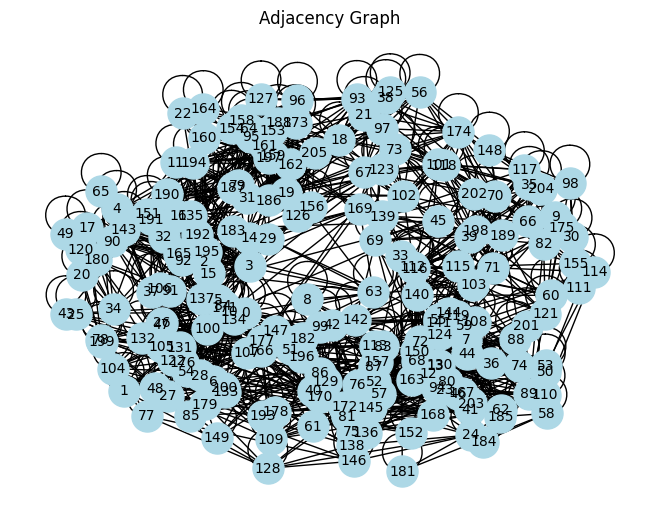

In [56]:
# YOUR CODE HERE
# Create a NetworkX graph from the adjacency matrix
adj_graph = nx.from_pandas_adjacency(new_df_adj)
pos = nx.spring_layout(adj_graph, k=0.5, iterations=50)  # Adjust k and iterations as needed
nx.draw(adj_graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Adjacency Graph")
plt.show()

#### Preprocessing and train test split

In [57]:
# YOUR CODE HERE
train_size = int(0.8 * len(df_speed))
train_data = df_speed[:train_size]
test_data = df_speed[train_size:]

#### Prepare Time series data


Aim is to use 50 minutes of historical speed observations to predict the speed in future (1 hour ahead)

* Choose windows of 10 historical observations i.e. 5 * 10 = 50 minutes (`seq_len`) for each segment as the input and use it to predict the speed after 5 * 12 = 60 minutes (target) using the sliding window approach.

**Note:**
The below parameters
-  `seq_len` is the size of the past window of information.
- `pre_len` is future prediction ( 1 hour in future = 12 * 5 minutes)



Steps:

* Prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a **sequence of past observations as input to an output observation**, so the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

* Choose to use 50 minutes of historical speed observations to predict the speed in future (eg. 1 hour ahead). First reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later as the prediction label. This can be performed using a sliding window approach:

    - Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict.

    - Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict.

    - Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

  *Note: The above steps are done for each sensor.*

Define a function below to return the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

Each **training observation** is 10 historical speeds **(seq_len).**

Each **training prediction** is the speed 60 minutes later **(pre_len).**

In [69]:
df_speed

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,...,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,...,42.708333,69.666667,64.388889,57.972222,66.708333,57.277778,64.986111,58.902778,69.285714,58.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,65.555556,65.111111,64.111111,61.111111,66.000000,66.777778,64.777778,58.000000,61.444444,65.875000,...,47.000000,69.000000,62.666667,67.222222,68.222222,55.333333,67.333333,62.000000,64.444444,64.111111
2012,66.625000,66.625000,65.750000,64.750000,67.375000,67.500000,67.250000,64.500000,57.875000,65.714286,...,42.250000,68.000000,64.375000,57.750000,67.500000,66.625000,57.750000,61.875000,66.125000,63.875000
2013,66.375000,66.375000,63.750000,63.750000,67.625000,68.375000,65.000000,64.625000,61.125000,62.000000,...,45.750000,65.000000,64.500000,65.750000,64.375000,65.375000,68.875000,60.625000,69.625000,62.375000
2014,64.666667,66.555556,66.888889,59.888889,65.111111,67.000000,65.111111,66.000000,65.111111,65.000000,...,44.555556,69.222222,59.000000,58.444444,66.666667,65.222222,68.222222,59.444444,68.333333,62.888889


In [75]:
df_speed.iloc[10:32, 1:]

,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
10,63.666667,65.111111,61.111111,66.555556,67.111111,65.000000,60.888889,47.000000,60.000000,61.222222,...,45.000000,65.500000,57.666667,57.444444,67.666667,64.777778,62.888889,60.555556,67.222222,60.000000
11,67.750000,66.875000,60.000000,64.750000,66.285714,61.250000,63.250000,52.625000,58.250000,60.875000,...,44.625000,68.142857,60.000000,58.750000,61.500000,62.125000,68.500000,57.000000,66.500000,59.428571
12,67.000000,58.500000,62.250000,66.375000,67.500000,63.125000,68.375000,56.000000,65.714286,60.500000,...,42.375000,69.000000,53.625000,55.142857,69.250000,61.750000,61.875000,53.125000,70.000000,63.500000
13,62.666667,65.777778,59.777778,66.888889,64.333333,66.111111,65.666667,59.222222,64.000000,60.222222,...,42.000000,66.222222,61.333333,55.333333,61.777778,64.000000,64.000000,52.555556,66.222222,62.333333
14,67.000000,55.000000,59.125000,67.625000,67.000000,65.125000,62.375000,59.875000,62.875000,50.250000,...,44.375000,65.875000,59.000000,53.000000,67.375000,66.250000,68.250000,54.250000,67.250000,58.375000
15,65.555556,68.111111,59.888889,61.333333,68.333333,59.666667,66.888889,57.000000,57.555556,58.222222,...,43.777778,61.555556,62.777778,56.500000,53.555556,62.666667,68.000000,61.111111,68.222222,61.444444
16,65.500000,60.750000,57.250000,67.875000,65.000000,64.875000,66.500000,60.000000,56.857143,56.375000,...,40.375000,65.428571,60.750000,61.000000,62.625000,57.875000,59.750000,51.125000,66.000000,60.285714
17,66.000000,68.222222,64.777778,68.333333,65.111111,66.555556,66.444444,48.777778,59.666667,59.444444,...,49.888889,66.222222,55.888889,60.111111,56.666667,61.111111,65.000000,59.444444,69.222222,62.111111
18,61.555556,68.111111,57.666667,65.000000,65.111111,65.222222,63.888889,53.444444,57.888889,54.222222,...,41.000000,67.666667,54.888889,53.333333,64.000000,63.555556,68.777778,61.666667,65.888889,54.888889
19,63.875000,65.375000,60.250000,62.500000,67.125000,63.875000,62.625000,60.500000,55.625000,56.000000,...,39.500000,63.375000,59.250000,60.500000,42.500000,64.750000,64.750000,59.000000,67.000000,57.750000


In [65]:
seq_len = 10
pre_len = 12
# YOUR CODE HERE
# def prepare_data(data, seq_len, pre_len):
#     X, y = [], []
#     for i in range(len(data) - seq_len - pre_len + 1):
#         X.append(data[i:i+seq_len])
#         y.append(data[i+seq_len:i+seq_len+pre_len])
#     return np.array(X), np.array(y)

def prepare_data(data, seq_len, pre_len):
    X, y = [], []
    num_features = len(data.columns) - 1  # Number of features (excluding time)
    for i in range(len(data) - seq_len - pre_len + 1):
        X.append(data.iloc[i:i+seq_len, 1:].values)  # Exclude time column and convert to NumPy array
        y.append(data.iloc[i+seq_len:i+seq_len+pre_len, 1:].values)  # Exclude time column and convert to NumPy array
    return np.array(X), np.array(y)

X,y = prepare_data(df_speed, seq_len, pre_len)

### Build and Train the LSTM model and plot the loss results (3 points)

In [66]:
# YOUR CODE HERE
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len, X.shape[2])))  # Use X.shape[2] for input features dimension
model.add(Dense(pre_len * X.shape[2])) # Output layer to match y shape
model.add(keras.layers.Reshape((pre_len, X.shape[2]))) # Reshape to (pre_len, num_sensors)
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 2160.4363
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 131.0832
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 115.5571
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109.6319
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.9954
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96.6096
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 88.7922
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.6500
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76.3491
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.5263
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.7191
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.9099
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.2424
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.3391
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.63

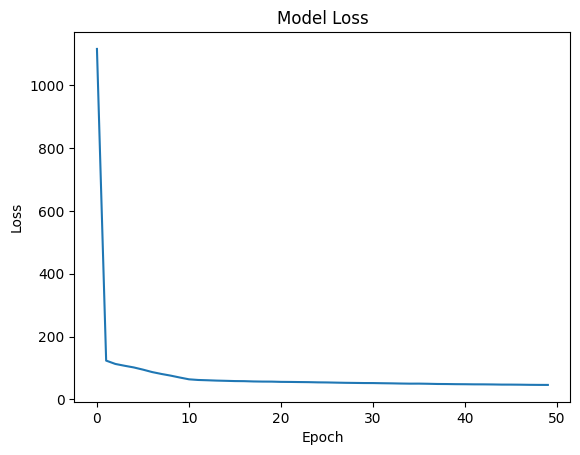

In [67]:
# YOUR CODE HERE to plot the loss
plt.plot(model.history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### StellarGraph Graph Convolution and LSTM model ( 3 points)

In order to use the model, we need:

* An **N by N** adjacency matrix, which describes the distance relationship between the N sensors,

* An **N by T** feature matrix, which describes the ($f_1, .., f_T$) speed records over T timesteps for the N sensors.

Arguments of GCN_LSTM:
  - seq_len: No. of LSTM cells

  - adj: unweighted/weighted adjacency matrix

  - gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.

  - lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.

  - gc_activations (list of str or func): Activations applied to each layer's output.

  - lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.

In [ ]:
# Implement GCN-LSTM
# YOUR CODE HERE

#### Rescale values
Rescale the predicted values to the original value range of the timeseries.

In [ ]:
# YOUR CODE HERE

### Plot the predictions and Loss of each sensor ( 2 points)

* Select any one sensor's prediction and plot the graph.

In [ ]:
# YOUR CODE HERE

#### Plot error (MAE and MSE) for all the sensors

In [ ]:
# YOUR CODE HERE

#### Report Analysis

  * Discuss: Why is this called a spatio-temporal problem?

  * Discuss: In what way is GCN-LSTM more useful for the traffic prediction task than LSTM?